# Kütüphanelerin Yüklenmesi

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.datasets import cifar10,fashion_mnist
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [1]:
# fashion_mnist veri setini yükle
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Veriyi düzleştir
x_train_flat = x_train.reshape(-1, 28 * 28 )
x_test_flat = x_test.reshape(-1, 28 * 28 )

# StandardScaler ile standartlaştırma
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Eğitim ve doğrulama veri setini ayır veri setlerinin tutarlı olduğundan emin olmak için stratify kullanıldı
x_train, x_val, y_train, y_val = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Sınıf etiketlerini kategorik hale getir
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# RBF sınıfı Oluşturma

In [ ]:
# RBF özel katmanını tanımla
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_centers, gamma):
        super(RBFLayer, self).__init__()
        self.num_centers = num_centers
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            shape=(self.num_centers, input_shape[-1]),
            initializer='random_normal',
            trainable=True,
            name="centers"
        )

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - self.centers
        return tf.exp(-self.gamma * tf.reduce_sum(tf.square(diff), axis=-1))

# RBF modelini tanımlayan fonksiyon
def create_rbf_model(num_centers, gamma):
    model = Sequential([
        RBFLayer(num_centers=num_centers, gamma=gamma),
        Dense(10, activation='softmax')  # Çıkış katmanı (10 sınıf için)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hiperparametre optimizasyonu

In [2]:
# Grid Search parametreleri Gamma: Gamma'nın çok büyük veya çok küçük olması, modelin yetersiz öğrenmesine yol açabilir.
rbf_params = {
    'num_centers': [50, 100, 200],
    'gamma': [0.01, 0.001]
}

# RBF modelinin eğitim ve performans analizi
best_accuracy = 0
best_params = None
best_rbf_model = None

for num_centers in rbf_params['num_centers']:
    for gamma in rbf_params['gamma']:
        # KMeans ile merkezleri belirle
        kmeans = KMeans(n_clusters=num_centers, random_state=42)
        kmeans.fit(x_train)
        centers = kmeans.cluster_centers_

        # Modeli oluştur
        model = create_rbf_model(num_centers=num_centers, gamma=gamma)
        # history sayesinde kayp ve doğruluk görselleştirilmesi yapılır.
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                             epochs=10, batch_size=64, verbose=0)

        # Doğrulama setinde tahmin yap
        y_pred = np.argmax(model.predict(x_val), axis=1)
        y_true = np.argmax(y_val, axis=1)

        # Performans metriklerini hesapla
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        acc = accuracy_score(y_true, y_pred)

        print(f"Params: {num_centers}, Gamma: {gamma} -> Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        # En iyi modeli kaydet
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = (num_centers, gamma)
            best_rbf_model = model

print(f"RBF için en iyi parametreler: {best_params} -> Acc: {best_accuracy:.4f}")

375/375 [==============================] - 1s 2ms/step
Params: 50, Gamma: 0.01 -> Acc: 0.5529, Precision: 0.6138, Recall: 0.5529, F1: 0.5519
375/375 [==============================] - 1s 3ms/step
Params: 50, Gamma: 0.001 -> Acc: 0.7765, Precision: 0.7680, Recall: 0.7765, F1: 0.7694
375/375 [==============================] - 2s 6ms/step
Params: 100, Gamma: 0.01 -> Acc: 0.6163, Precision: 0.6835, Recall: 0.6163, F1: 0.6219
375/375 [==============================] - 2s 5ms/step
Params: 100, Gamma: 0.001 -> Acc: 0.8029, Precision: 0.7984, Recall: 0.8029, F1: 0.7988
375/375 [==============================] - 3s 9ms/step
Params: 200, Gamma: 0.01 -> Acc: 0.6490, Precision: 0.7096, Recall: 0.6490, F1: 0.6542
375/375 [==============================] - 3s 9ms/step
Params: 200, Gamma: 0.001 -> Acc: 0.8188, Precision: 0.8176, Recall: 0.8188, F1: 0.8163
RBF için en iyi parametreler: (200, 0.001) -> Acc: 0.8188


# Eğitim Süreci Loss ve Accuracy Grafikleri
- Eğitim sürecinde elde ettiğiniz doğruluk ve kayıp metriklerini görselleştirmek için aşağıdaki adımları izleyebilirsiniz

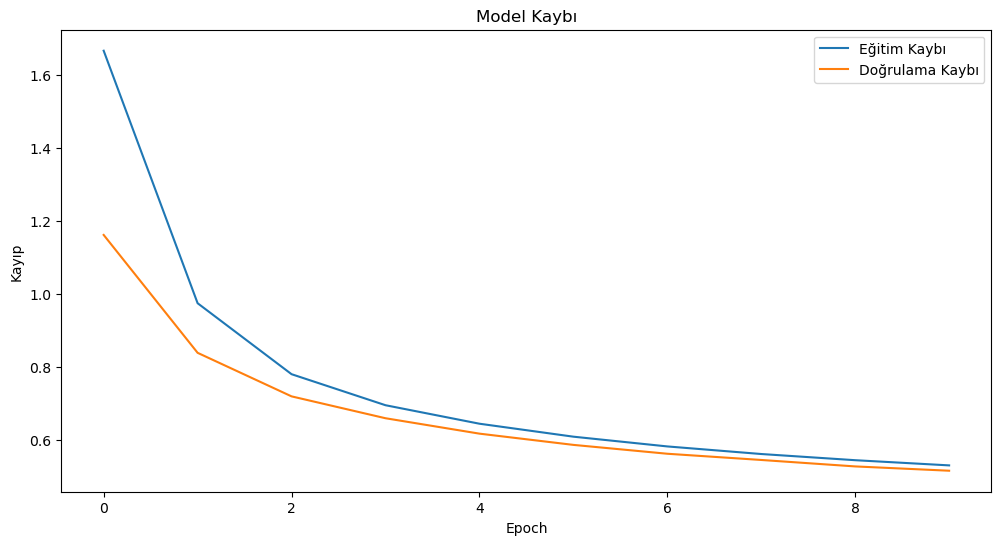

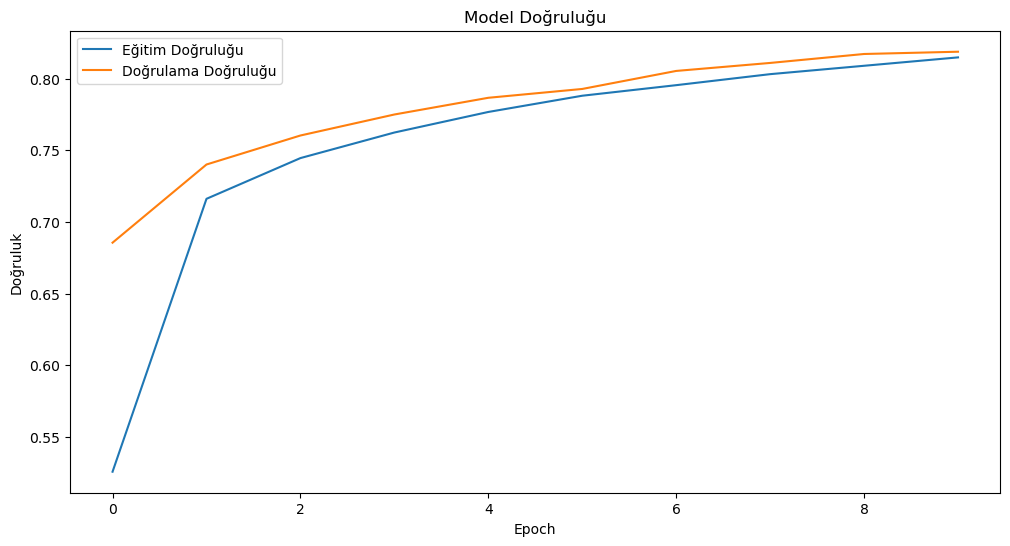

In [3]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybını görselleştir
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Model Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

# Eğitim ve doğrulama doğruluğunu görselleştir
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Model Doğruluğu')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.show()

# Modeli eğittikten sonra history nesnesini kullanarak grafikler oluştur
plot_loss(history)
plot_accuracy(history)

# Confusion Matrix ile Sınıf Performansı
- Modelinizin sınıf performansını daha ayrıntılı görmek için bir confusion matrix oluşturabilirsiniz. Bu, modelin hangi sınıflarda hata yaptığını gösterir.

313/313 [==============================] - 3s 10ms/step

RBF Modeli - Sınıflandırma Raporu
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1000
           1       0.98      0.93      0.96      1000
           2       0.76      0.61      0.68      1000
           3       0.77      0.88      0.82      1000
           4       0.67      0.79      0.72      1000
           5       0.88      0.88      0.88      1000
           6       0.54      0.46      0.50      1000
           7       0.87      0.88      0.88      1000
           8       0.89      0.95      0.92      1000
           9       0.89      0.90      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.80      0.81      0.80     10000
weighted avg       0.80      0.81      0.80     10000



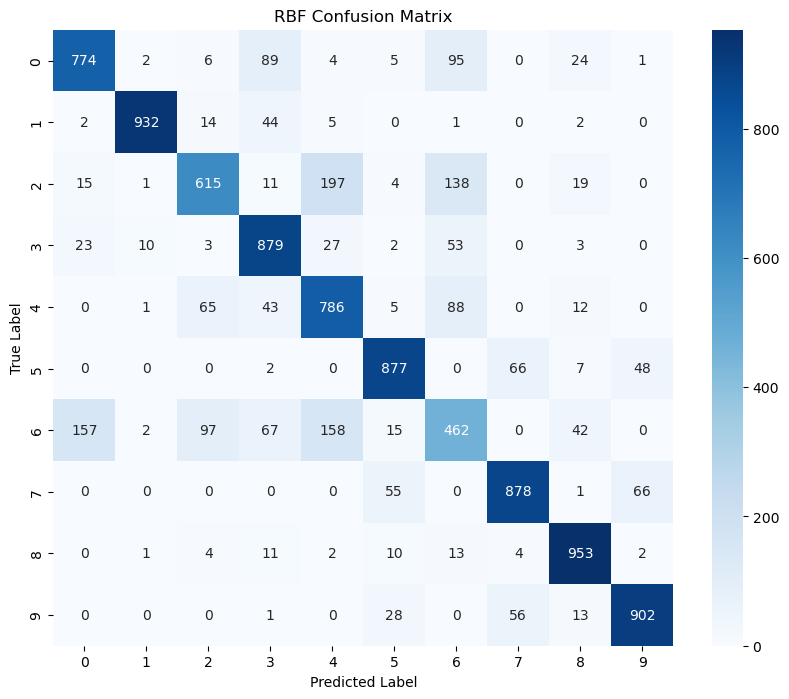

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix'i çizdirme fonksiyonu
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = range(10)  # CIFAR-10 sınıf sayısı
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# 2. RBF Modeli için en iyi sonucu elde eden modelin tahminlerini alın
rbf_y_pred = np.argmax(best_rbf_model.predict(x_test_scaled), axis=1)
rbf_y_true = np.argmax(y_test, axis=1)

print("\nRBF Modeli - Sınıflandırma Raporu")
print(classification_report(rbf_y_true, rbf_y_pred))

plot_confusion_matrix(rbf_y_true, rbf_y_pred, title="RBF Confusion Matrix")

# ROC Eğrisi 
- Sınıflar arasında karar sınırlarını incelemek için ROC eğrisini de çizebilirsiniz. Bu, modelinizin True Positive Rate (TPR) ve False Positive Rate (FPR) değerleri arasındaki ilişkiyi gösterir.

313/313 [==============================] - 3s 10ms/step


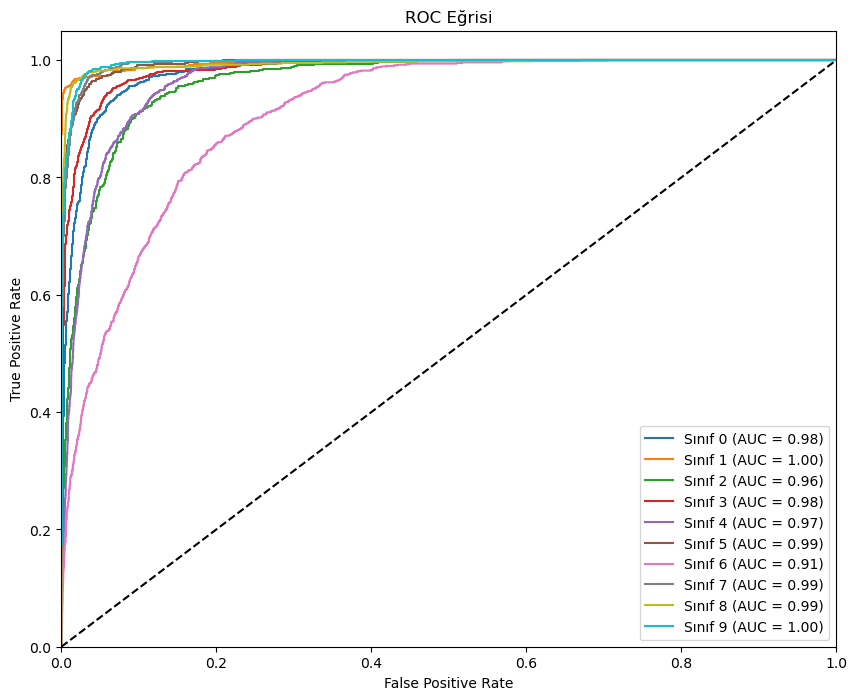

In [7]:
from sklearn.metrics import roc_curve, auc

# Her sınıf için ROC eğrisini çizme
def plot_roc_curve(y_true, y_pred, num_classes=10):
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Sınıf {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Eğrisi')
    plt.legend(loc='lower right')
    plt.show()

# Test verisi üzerinde ROC eğrisini çiz
y_pred_prob = best_rbf_model.predict(x_test_scaled)
plot_roc_curve(y_test, y_pred_prob)


# F1 Skoru, Precision ve Recall ile Performans Görselleştirme

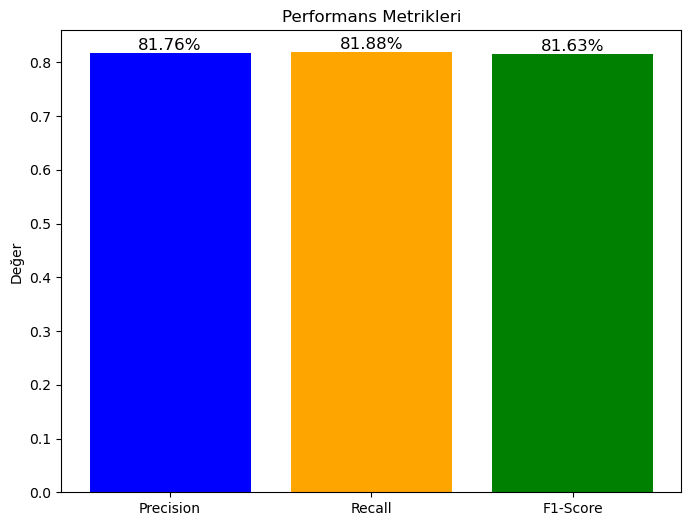

In [9]:
# Metrikleri görselleştir
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

# Yüzdelik değerleri hazırlama
percentages = [f"{value * 100:.2f}%" for value in values]

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.title('Performans Metrikleri')
plt.ylabel('Değer')

# Her sütunun üzerine yüzdelik değerini ekle
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             percentage, ha='center', va='bottom', fontsize=12)

plt.show()